In [1]:
import numpy as np
import scipy.stats
import sklearn.decomposition
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none' # export SVG text as text, not paths
plt.rcParams['axes.facecolor'] = 'w' # white axes background
plt.rcParams['savefig.facecolor'] = 'w' # white main background, for blog posts

# Part 2: Association tests and feature selection

## 1. Load Civ5 data as in Part 1, and new Civ5 metadata

In [2]:
df = pd.read_csv('civdata.csv', index_col=0).T # Part 1 data
print(df.shape)
df.head()

(43, 63)


,Boldness,Chattiness,Denounce Willingness,Diplomatic Balance,Friendship Willingness,Forgiveness,Loyalty,Meanness,City-State Competitiveness,Neediness,...,Friendly,Guarded,Hostile,Neutrality,War,CS Bully,CS Conquest,CS Friendly,CS Ignore,CS Protect
Ahmad al-Mansur,4,6,5,5,6,5,6,5,5,6,...,8,6,4,5,5,4,4,6,4,6
Alexander,8,7,7,3,4,5,4,7,3,4,...,5,5,7,4,6,3,4,5,4,8
Ashurbanipal,6,3,6,5,5,4,5,5,3,4,...,5,5,6,5,8,5,7,4,4,3
Askia,7,5,5,6,6,4,6,6,4,4,...,6,6,6,5,7,7,8,5,5,4
Attila,8,5,6,4,3,4,4,8,3,3,...,3,3,8,5,8,8,7,4,5,3


In [3]:
''' Convert encoding to UTF-8 and drop empty rows/columns if necessary '''
df_meta = pd.read_csv('civmetadata.csv', index_col=0)
print(df_meta.shape)
df_meta.head()

(43, 8)


,Born,Death,Age,Era,Gender,Civilization,Continent,Region
Leader,,,,,,,,
Ahmad al-Mansur,1549.0,1603.0,54.0,Renaissance,Male,Morrocan,Africa,Africa
Alexander,-356.0,-323.0,33.0,Classical,Male,Greek,Europe,Europe
Ashurbanipal,-685.0,-627.0,58.0,Ancient,Male,Assyrian,Asia,Middle East
Askia,1442.0,1538.0,96.0,Renaissance,Male,Songhai,Africa,Africa
Attila,406.0,453.0,47.0,Classical,Male,Hunnic,Asia,Asia


## 2. Examine raw distributions by era, gender, and region

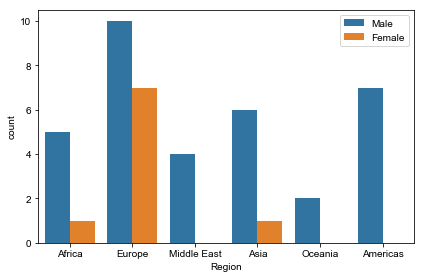

In [4]:
%matplotlib inline
''' Counts by region and gender '''
sns.countplot(x='Region', hue='Gender', data=df_meta)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figures/region_gender_counts.png', format='png', dpi=90)

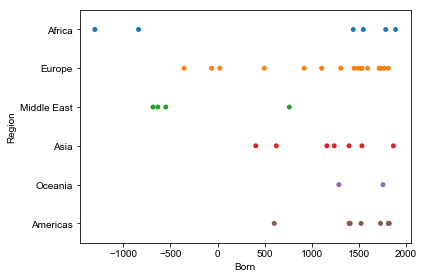

In [5]:
sns.stripplot(x='Born', y='Region', data=df_meta)
plt.tight_layout()
plt.savefig('figures/region_year_counts.png', format='png', dpi=90)

In [6]:
print(sorted(df_meta['Region'].unique()))

['Africa', 'Americas', 'Asia', 'Europe', 'Middle East', 'Oceania']


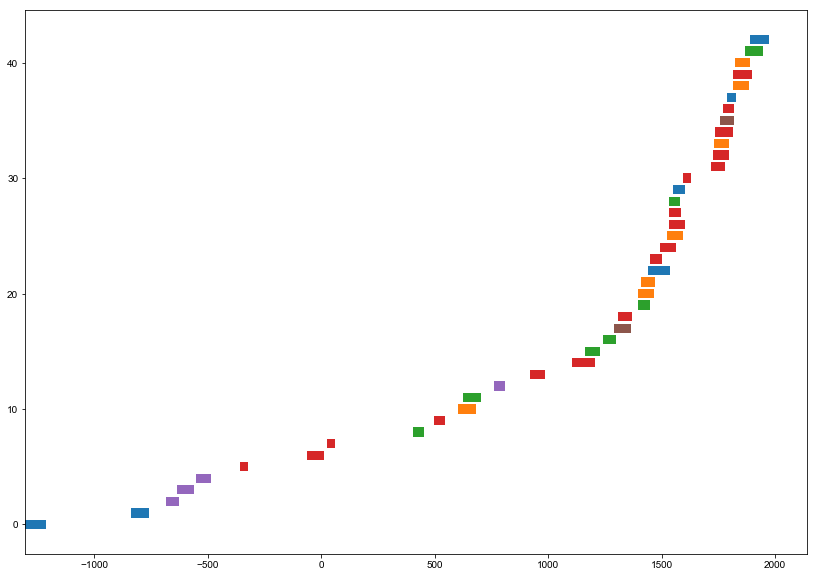

In [7]:
regions = sorted(df_meta['Region'].unique())
df_meta_sorted = df_meta.sort_values('Born')
df_meta_sorted['Born_Rank'] = range(df_meta.shape[0])

fig, ax = plt.subplots(1,1,figsize=(14,10))
for i,region in enumerate(regions):
    df_region = df_meta_sorted[df_meta_sorted['Region'] == region]
    ax.barh(bottom=df_region['Born_Rank'].values, 
             width=df_region['Death'].values - df_region['Born'].values,
             left=df_region['Born'])

## 3. PCA Projections with metadata

### Repeating PCA same as in Part 1

In [8]:
''' Center values such that each feature has mean 0
    Not scaling for variance since all values already bounded 1-12 '''
X = df.values
means = X.mean(axis=0)
X_cent = X - means[np.newaxis,:]
df_cent = pd.DataFrame(index=df.index, columns=df.columns, data=X_cent)

pca = sklearn.decomposition.PCA(n_components=np.min(X_cent.shape))
pca.fit(X_cent)
top2pcs = pca.transform(X_cent)[:,:2] # coordinates of leaders in top 2 PC space
top2var = pca.explained_variance_ratio_[:2] # variance explained by top 2 PCs

In [29]:
''' Define a function to create an attributed-color PCA plot '''
def pca_with_metadata(attribute, ax, value_order=None):
    df_pca = pd.DataFrame(index=df.index, columns=['X','Y'], data=top2pcs)
    value_order = value_order if value_order else sorted(df_meta.loc[:,attribute].unique())
    for unique_value in value_order:
        df_cat = df_pca[df_meta[attribute] == unique_value]
        ax.scatter(df_cat['X'], df_cat['Y'], label=unique_value)
    ax.set_xlabel('PC1 (' + str(round(100*top2var[0],1)) + '%)')
    ax.set_ylabel('PC2 (' + str(round(100*top2var[1],1)) + '%)')
    ax.axvline(x=0, ymin=np.min(top2pcs[:,1]), ymax=np.max(top2pcs[:,1]), color='lightgray', ls='--')
    ax.axhline(y=0, xmin=np.min(top2pcs[:,0]), xmax=np.max(top2pcs[:,0]), color='lightgray', ls='--')
    ax.legend()
    plt.tight_layout()

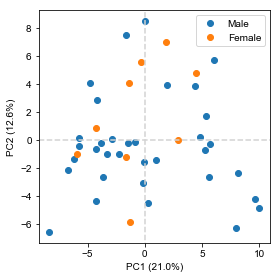

In [35]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
pca_with_metadata('Gender', ax, ['Male','Female'])
plt.savefig('figures/pca_biplot_gender.png', format='png', dpi=90)

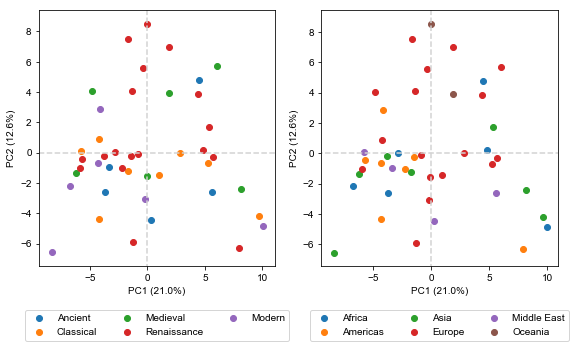

In [43]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
pca_with_metadata('Era', axs[0], ['Ancient', 'Classical' ,'Medieval', 'Renaissance', 'Modern'])
pca_with_metadata('Region', axs[1])

for ax in axs: # move legends to bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig('figures/pca_biplot_era_region.png', format='png', dpi=90, bbox_inches='tight')

## 4. Association studies of leader biases vs. leader demographics

In [49]:
ignore_biases = ['Trade Origin', 'Trade Destination', 'Sea Trade', 'Land Trade', 'Airlift', 'Archaeology']

### 4.1 Leader biases vs. gender: Mann-Whitney U-test

In [45]:
male_leaders = (df_meta[df_meta['Gender'] == 'Male']).index
female_leaders = (df_meta[df_meta['Gender'] == 'Female']).index
print 'Male Leaders:', len(male_leaders)
print 'Female Leaders:', len(female_leaders)

Male Leaders: 34
Female Leaders: 9


In [52]:
biases = filter(lambda x: not x in ignore_biases, df.columns)
df_mwtest = pd.DataFrame(index=biases, columns=['U', 'p', 'log10(p)'])
for bias in biases:
    male_values = df.loc[male_leaders, bias].values
    female_values = df.loc[female_leaders, bias].values
    U, pval = scipy.stats.mannwhitneyu(male_values, female_values)
    df_mwtest.at[bias, 'U'] = U
    df_mwtest.at[bias, 'p'] = pval
    df_mwtest.at[bias, 'log10(p)'] = np.log10(pval)

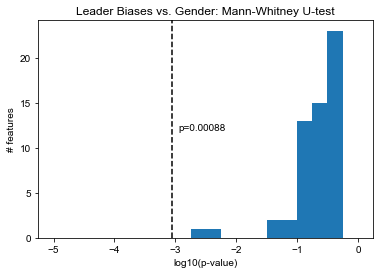

In [58]:
threshold = 0.05 / df_mwtest.shape[0]
log_pvals = df_mwtest.loc[:,'log10(p)'].values.astype(float)
plt.hist(log_pvals, bins=np.arange(-5,0.25,0.25))
plt.axvline(x=np.log10(threshold), c='k', ls='--')
plt.xlabel('log10(p-value)')
plt.ylabel('# features')
plt.text(np.log10(threshold)+0.1, 12, 'p=0.00088')
plt.title('Leader Biases vs. Gender: Mann-Whitney U-test')
plt.savefig('figures/mann-whitney_pvalues.png', format='png', dpi=90)